In [1]:
%pip install -qU langchain_community pypdf

Note: you may need to restart the kernel to use updated packages.


In [9]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import PyPDFLoader

filename = "/home/james/projects/learnings/AI_Learnings/langchain/langgraph-test/data_sources/2025q1-alphabet-earnings-release.pdf"
loader = PyPDFLoader(file_path=filename)
docs = []
docs = loader.load()

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=30,
    add_start_index=True)

all_splits = text_splitter.split_documents(docs)

print(f"Split the pdf into {len(all_splits)} sub-documents.")

Split the pdf into 17 sub-documents.


In [11]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# embedding model
embed_model = OpenAIEmbeddings(model="text-embedding-3-large")

# vector storage
vector_store = InMemoryVectorStore(embedding=embed_model)

# add document chunks to the vector store to get index chunks
document_ids = vector_store.add_documents(documents=all_splits)

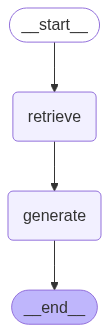

In [5]:
from typing import TypedDict, List
from IPython.display import Image
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, END, StateGraph
from langchain_openai import ChatOpenAI


prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model='gpt-4o')

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    print("--Retrieving Information--")
    question = state['question']
    retrieved_docs = vector_store.similarity_search(query=question,k=4)
    return {'context': retrieved_docs}

def generate(state: State):
    print("--Generating Response--")
    docs_contents =  "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({'question': state['question'], 'context': state['context']})
    response = llm.invoke(messages)
    return {'answer': response}
        
builder = StateGraph(State)

builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [7]:
for event in graph.stream({'question': 'How does Nike does in Q1 2025'},stream_mode='values'):
    if event.get('answer',''):
        event['answer'].pretty_print()

--Retrieving Information--
--Generating Response--
================================== Ai Message ==================================

I don't know. The provided context contains information only about Alphabet's performance in Q1 2025, not Nike's.


In [15]:
from langchain.tools.retriever import create_retriever_tool

retriever = vector_store.as_retriever()
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search analysis for SAAB.",
)
retriever_tool.invoke({"query": "types of reward hacking"})

'resource, and legal costs, including certain fines and settlements. Charges associated with employee severance \nand office space reductions are also not allocated to our segments. Additionally, hedging gains (losses) related to \nrevenue are not allocated to our segments.\n7\n\ntransparency with respect to key metrics used by management in its financial and operational decision-making and (2) \nthey are used by our institutional investors and the analyst community to help them analyze the health of our business.\nThere are a number of limitations related to the use of non-GAAP financial measures. We compensate for these \nlimitations by providing specific information regarding the GAAP amounts excluded from these non-GAAP financial \nmeasures and evaluating these non-GAAP financial measures together with their relevant financial measures in \naccordance with GAAP.\nFor more information on these non-GAAP financial measures, please see the sections captioned “ Reconciliation from \nGAA